In [1]:
#import statements, hyper params, models
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from numpy import random
import matplotlib.pyplot as plt


EPOCHS = 50 #number of passes of whole data
BATCH_SIZE = 64 #size of data going through at once
LEARNING_RATE = 0.001
NEURONS=5
XSIZE=10000
BINOMPROB=.5
#X=random.rand(XSIZE, 5)
X=np.random.normal(0, 1, size=(XSIZE, 5))
y=[]
for i in range(XSIZE):
    y.append(random.binomial(1, BINOMPROB, size=None))




#Data class
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#Data loaders (to look at data) and deal with data (training and testing)
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
def binary_acc(y_pred, y_test): 
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def trainnetwork(network, train_loader,stats=True):
    network.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)


    network.train()
    for e in range(1, EPOCHS+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = network(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        
def evalnetwork(network, test_loader, stats=True):
    y_pred_list =[]
    network.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = network(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())


    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    if(stats):
        statistics(y_pred_list)
    #return y_fullmodelpred_list


def resettruth(truth_loader):
    y_pred_list =[]
    GroundTruth.eval()
    with torch.no_grad():
        for X_batch in truth_loader:
            X_batch = X_batch.to(device)
            y_test_pred = GroundTruth(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())


    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    return y_pred_list

    
    

def statistics(y_pred_list):
    correctcounter=0
    for i in range(len(y_pred_list)):
        if y_pred_list[i]==y_test[i]:
            correctcounter=correctcounter+1       

    print("# correct: ",correctcounter, " out of ", len(y_test))

    print("Model statistics")
    print(classification_report(y_test, y_pred_list))    
    
#model class 5 layers, then an output layer
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        self.layer_1 = nn.Linear(5, NEURONS) 
        self.layer_2 = nn.Linear(NEURONS, NEURONS) 
        self.layer_3 = nn.Linear(NEURONS, NEURONS)
        self.layer_4 = nn.Linear(NEURONS,NEURONS)
        self.layer_5 = nn.Linear(NEURONS, NEURONS) 
        self.layer_out = nn.Linear(NEURONS, 1) #output layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        self.batchnorm1 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2 = nn.BatchNorm1d(NEURONS)
        self.batchnorm3 = nn.BatchNorm1d(NEURONS)
        self.batchnorm4 = nn.BatchNorm1d(NEURONS)
        self.batchnorm5 = nn.BatchNorm1d(NEURONS)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)        
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
#parallel model (two 5 layer models, with output going into new output layer)
class parallelmodel(nn.Module):
    def __init__(self, originalmodel):
        super(parallelmodel, self).__init__()
        self.layer1_1 = copy.deepcopy(originalmodel.layer_1)
        self.layer1_2 = copy.deepcopy(originalmodel.layer_2)
        self.layer1_3 = copy.deepcopy(originalmodel.layer_3)
        self.layer1_4 = copy.deepcopy(originalmodel.layer_4)
        self.layer1_5 = copy.deepcopy(originalmodel.layer_5)
        self.layer1_out = copy.deepcopy(originalmodel.layer_out)
        
        self.relu1 = copy.deepcopy(originalmodel.relu)        
        self.dropout1 = copy.deepcopy(originalmodel.dropout)
        
        self.batchnorm1_1 = copy.deepcopy(originalmodel.batchnorm1)
        self.batchnorm1_2 = copy.deepcopy(originalmodel.batchnorm2)
        self.batchnorm1_3 = copy.deepcopy(originalmodel.batchnorm3)
        self.batchnorm1_4 = copy.deepcopy(originalmodel.batchnorm4)
        self.batchnorm1_5 = copy.deepcopy(originalmodel.batchnorm5)
        #self.batchnorm1_out=nn.BatchNorm1d(1)

        
        self.batchnorm2_1 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_2 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_3 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_4 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2_5 = nn.BatchNorm1d(NEURONS)
        #self.batchnorm2_out=nn.BatchNorm1d()
        
        self.layer2_1 = nn.Linear(5, NEURONS) 
        self.layer2_2 = nn.Linear(NEURONS, NEURONS) 
        self.layer2_3 = nn.Linear(NEURONS,NEURONS)
        self.layer2_4 = nn.Linear(NEURONS, NEURONS)
        self.layer2_5 = nn.Linear(NEURONS, NEURONS) 
        self.layer2_out = nn.Linear(NEURONS, 1) 
        
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)
        
        #changed bias
        self.outputlayer= nn.Linear(2, 1, bias=False )
        self.alpha=[]
        self.beta=[]
        
        
        
        
        
    def forward(self, inputs):
        x = self.relu1(self.layer1_1(inputs))
        x = self.batchnorm1_1(x)
        x = self.relu1(self.layer1_2(x))
        x = self.batchnorm1_2(x)
        x = self.relu1(self.layer1_3(x))
        x = self.batchnorm1_3(x)
        x = self.relu1(self.layer1_4(x))
        x = self.batchnorm1_4(x)
        x = self.relu1(self.layer1_5(x))
        x = self.batchnorm1_5(x) 
        x = self.dropout1(x)
        x = self.layer1_out(x)
        x=torch.sigmoid(x)
        
        
        y = self.relu2(self.layer2_1(inputs))
        y = self.batchnorm2_1(y)
        y = self.relu2(self.layer2_2(y))
        y = self.batchnorm2_2(y)
        y = self.relu2(self.layer2_3(y))
        y = self.batchnorm2_3(y)
        y = self.relu2(self.layer2_4(y))
        y = self.batchnorm2_4(y)
        y = self.relu2(self.layer2_5(y))
        y = self.batchnorm2_5(y)        
        y = self.dropout2(y)
        y = self.layer2_out(y)
        y=torch.sigmoid(y)
        
        z=self.outputlayer(torch.cat([x, y], dim=1))
        return z
        
#parrallel submodels
class parrallel_submodel(nn.Module):
    def __init__(self):
        super(parrallel_submodel, self).__init__()
        self.layer_1 = nn.Linear(5, NEURONS) 
        self.layer_2 = nn.Linear(NEURONS, NEURONS) 
        self.layer_3 = nn.Linear(NEURONS, NEURONS)
        self.layer_4 = nn.Linear(NEURONS,NEURONS)
        self.layer_5 = nn.Linear(NEURONS, NEURONS) 
        self.layer_out = nn.Linear(NEURONS, 1) #output layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
        self.batchnorm1 = nn.BatchNorm1d(NEURONS)
        self.batchnorm2 = nn.BatchNorm1d(NEURONS)
        self.batchnorm3 = nn.BatchNorm1d(NEURONS)
        self.batchnorm4 = nn.BatchNorm1d(NEURONS)
        self.batchnorm5 = nn.BatchNorm1d(NEURONS)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)        
        x = self.dropout(x)
        x = self.layer_out(x)
        x = torch.sigmoid(x)
        
        return x
    
#parallel model V2
class parallelmodel1(nn.Module):
    def __init__(self, originalmodel):
        super(parallelmodel1, self).__init__()

        self.pretrainednetwork=parrallel_submodel()
        
        
        
        
        self.pretrainednetwork.layer_1 = copy.deepcopy(originalmodel.layer_1)
        self.pretrainednetwork.layer_2 = copy.deepcopy(originalmodel.layer_2)
        self.pretrainednetwork.layer_3 = copy.deepcopy(originalmodel.layer_3)
        self.pretrainednetwork.layer_4 = copy.deepcopy(originalmodel.layer_4)
        self.pretrainednetwork.layer_5 = copy.deepcopy(originalmodel.layer_5)
        self.pretrainednetwork.layer_out = copy.deepcopy(originalmodel.layer_out)
        
        self.pretrainednetwork.relu = copy.deepcopy(originalmodel.relu)        
        self.pretrainednetwork.dropout = copy.deepcopy(originalmodel.dropout)
        
        self.pretrainednetwork.batchnorm_1 = copy.deepcopy(originalmodel.batchnorm1)
        self.pretrainednetwork.batchnorm_2 = copy.deepcopy(originalmodel.batchnorm2)
        self.pretrainednetwork.batchnorm_3 = copy.deepcopy(originalmodel.batchnorm3)
        self.pretrainednetwork.batchnorm_4 = copy.deepcopy(originalmodel.batchnorm4)
        self.pretrainednetwork.batchnorm_5 = copy.deepcopy(originalmodel.batchnorm5)

        
        self.untrainednetwork=parrallel_submodel()
        
        
        self.outputlayer= nn.Linear(2, 1, bias=False )
        
        

        self.alpha=[]
        self.beta=[]
        
        
        
        
        self.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[.5,0.5]]), requires_grad=True)
        self.alpha.append(.5)
        self.beta.append(.5)
        
    def forward(self, inputs):
        x=self.pretrainednetwork(inputs)
        y=self.untrainednetwork(inputs)
        z=self.outputlayer(torch.cat([x, y], dim=1))
        return z






    
    
#groundtruth model  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



baddata=True
while(baddata):
    GroundTruth = binaryClassification()

    
    

    
    
    scaler=StandardScaler()
    
    X_train = scaler.fit_transform(X) 
    X_test=scaler.fit_transform(X)
    
    train_data = trainData(torch.FloatTensor(X_train),torch.FloatTensor(y))
    test_data = testData(torch.FloatTensor(X_test))
    
    
    
    Truthloadertrain=DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    Truthtest= DataLoader(dataset=test_data, batch_size=1)

    
    
    
    
    
    trainnetwork(GroundTruth, Truthloadertrain)
    truth_list = resettruth(Truthtest)
    truthcounter=truth_list.count(1)
            
    
            
    if truthcounter/len(y)<BINOMPROB+.3 and truthcounter/len(y)>BINOMPROB-.3:
        baddata=False
        y=truth_list
        
        
        
        
    else:
        print("rejected truths ", truth_list.count(1))
        X=np.random.normal(0, 1, size=(XSIZE, 5))
        y=[]
        for i in range(XSIZE):
            y.append(random.binomial(1, BINOMPROB, size=None))

 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
train_data= trainData(torch.FloatTensor(X_train),torch.FloatTensor(y_train))
test_data = testData(torch.FloatTensor(X_test))
train_loader= DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)                      
test_loader = DataLoader(dataset=test_data, batch_size=1)
trained=binaryClassification()
trainnetwork(trained, train_loader)
evalnetwork(trained, test_loader)


    

# correct:  2972  out of  3300
Model statistics
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      1593
         1.0       0.90      0.91      0.90      1707

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [2]:
#train parralel model
parralel = parallelmodel(trained)
parralel.to(device)
criterion = nn.BCEWithLogitsLoss()

parralel.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[.9,0.05]]), requires_grad=True)
parralel.alpha.append(.9)
parralel.beta.append(.05)
epochlist=[]
losslist=[]

paroptimizer = optim.Adam(parralel.parameters(), lr=LEARNING_RATE)



#EPOCHS = 300 #number of passes of whole data
#BATCH_SIZE = 16 #size of data going through at once



#train trained model
parralel.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        paroptimizer.zero_grad()
        
        y_pred = parralel(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        paroptimizer.step()
        
        parralel.alpha.append(parralel.outputlayer.weight[0][0].detach().numpy().item())
        parralel.beta.append(parralel.outputlayer.weight[0][1].detach().numpy().item())
        
        epoch_loss += loss.item()

        epoch_acc += acc.item()
        
        

        
    epochlist.append(e)   
    losslist.append(epoch_loss/len(train_loader))
    #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

    
passlist=list(range(0,len(parralel.alpha)))
    
#losslist.insert(0, losslist[0])

  
print(len(parralel.alpha))
    
y_parmodelpred_list =[]
yparralelunrounded=[]
parralel.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = parralel(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        yparralelunrounded.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_parmodelpred_list.append(y_pred_tag.cpu().numpy())


y_parmodelpred_list = [a.squeeze().tolist() for a in y_parmodelpred_list]
yparralelunrounded=[a.squeeze().tolist() for a in yparralelunrounded]

print("truth guesses: ",y_parmodelpred_list.count(1))
print("false guesses: ",y_parmodelpred_list.count(0))
    
parmodelcounter=0
for i in range(len(y_parmodelpred_list)):
    if y_parmodelpred_list[i]==y_test[i]:
        parmodelcounter=parmodelcounter+1       

print("# correct: ",parmodelcounter, " out of ", len(y_test))
        
print("Full model statistics")
print(classification_report(y_test, y_parmodelpred_list))    
    
    
print("output weight: ", parralel.outputlayer.weight)

5251
truth guesses:  1757
false guesses:  1543
# correct:  3034  out of  3300
Full model statistics
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92      1593
         1.0       0.91      0.94      0.92      1707

    accuracy                           0.92      3300
   macro avg       0.92      0.92      0.92      3300
weighted avg       0.92      0.92      0.92      3300

output weight:  Parameter containing:
tensor([[ 3.3783, -2.6462]], requires_grad=True)


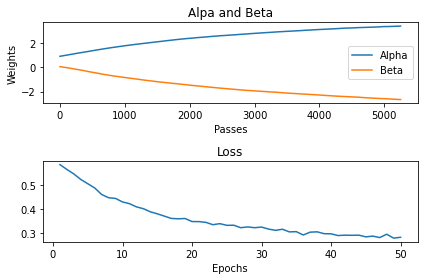

In [3]:
#graphs

fig, (weights, lossgraph) = plt.subplots(2)
weights.plot(passlist,parralel.alpha, label="Alpha")
weights.plot(passlist,parralel.beta, label="Beta")
weights.legend()

weights.set_xlabel('Passes')
weights.set_ylabel('Weights')
weights.set_title('Alpa and Beta')




plt.plot(epochlist,losslist, label="loss")

lossgraph.set_xlabel('Epochs')
lossgraph.set_label('Loss')
lossgraph.set_title('Loss')


fig.tight_layout()
#plt.savefig('e2fullparalelgraph3')



In [4]:
#half model stats

halfmodeltrained=binaryClassification()
halfmodellow=binaryClassification()

halfmodeltrained.layer_1 = copy.deepcopy(parralel.layer1_1)
halfmodeltrained.layer_2 = copy.deepcopy(parralel.layer1_2)
halfmodeltrained.layer_3 = copy.deepcopy(parralel.layer1_3)
halfmodeltrained.layer_4 = copy.deepcopy(parralel.layer1_4)
halfmodeltrained.layer_5 = copy.deepcopy(parralel.layer1_5)
halfmodeltrained.layer_out = copy.deepcopy(parralel.layer1_out)



halfmodeltrained.batchnorm1 = copy.deepcopy(parralel.batchnorm1_1)
halfmodeltrained.batchnorm2 = copy.deepcopy(parralel.batchnorm1_2)
halfmodeltrained.batchnorm3 = copy.deepcopy(parralel.batchnorm1_3)
halfmodeltrained.batchnorm4 = copy.deepcopy(parralel.batchnorm1_4)
halfmodeltrained.batchnorm5 = copy.deepcopy(parralel.batchnorm1_5)











halfmodellow.layer_1 = copy.deepcopy(parralel.layer2_1)
halfmodellow.layer_2 = copy.deepcopy(parralel.layer2_2)
halfmodellow.layer_3 = copy.deepcopy(parralel.layer2_3)
halfmodellow.layer_4 = copy.deepcopy(parralel.layer2_4)
halfmodellow.layer_5 = copy.deepcopy(parralel.layer2_5)
halfmodellow.layer_out = copy.deepcopy(parralel.layer2_out)



halfmodellow.batchnorm1 = copy.deepcopy(parralel.batchnorm2_1)
halfmodellow.batchnorm2 = copy.deepcopy(parralel.batchnorm2_2)
halfmodellow.batchnorm3 = copy.deepcopy(parralel.batchnorm2_3)
halfmodellow.batchnorm4 = copy.deepcopy(parralel.batchnorm2_4)
halfmodellow.batchnorm5 = copy.deepcopy(parralel.batchnorm2_5)

print("pretrained stats:")



y_pretrianedlist =[]
y_pretrainedunrounded=[]
halfmodeltrained.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = halfmodeltrained(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pretrainedunrounded.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_pretrianedlist.append(y_pred_tag.cpu().numpy())


y_pretrianedlist = [a.squeeze().tolist() for a in y_pretrianedlist]
y_pretrainedunrounded = [a.squeeze().tolist() for a in y_pretrainedunrounded]



correctcounter=0
for i in range(len(y_pretrianedlist)):
    if y_pretrianedlist[i]==y_test[i]:
        correctcounter=correctcounter+1 
        
        
print("Tained half model;")
print("Number correct model: ", correctcounter, " out of ", len(y_test))
print("precision=(# of correct)/(# of guessed)")
print("recall=(# of correct)/(total)")
print(classification_report(y_test, y_pretrianedlist))





print("untrained half stats:")
y_untrianedlist =[]
y_untrained_unrounded=[]
halfmodellow.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = halfmodellow(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_untrained_unrounded.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_untrianedlist.append(y_pred_tag.cpu().numpy())


y_untrianedlist = [a.squeeze().tolist() for a in y_untrianedlist]
y_untrained_unrounded = [a.squeeze().tolist() for a in y_untrained_unrounded]



correctcounter=0
for i in range(len(y_pretrianedlist)):
    if y_untrianedlist[i]==y_test[i]:
        correctcounter=correctcounter+1 
        

        
        
print("untained half model;")
print("Number correct model: ", correctcounter, " out of ", len(y_test))
print("precision=(# of correct)/(# of guessed)")
print("recall=(# of correct)/(total)")
print(classification_report(y_test, y_untrianedlist))






pretrained stats:
Tained half model;
Number correct model:  2960  out of  3300
precision=(# of correct)/(# of guessed)
recall=(# of correct)/(total)
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      1593
         1.0       0.91      0.89      0.90      1707

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300

untrained half stats:
untained half model;
Number correct model:  428  out of  3300
precision=(# of correct)/(# of guessed)
recall=(# of correct)/(total)
              precision    recall  f1-score   support

         0.0       0.10      0.10      0.10      1593
         1.0       0.16      0.15      0.15      1707

    accuracy                           0.13      3300
   macro avg       0.13      0.13      0.13      3300
weighted avg       0.13      0.13      0.13      3300



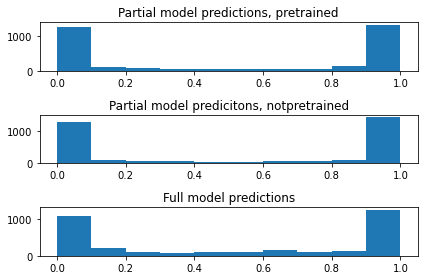

In [5]:
#histograms
xbins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
fig=plt.figure()
trained_histo=fig.add_subplot(3,1,1)
untrained_histo=fig.add_subplot(3,1,2)
full_histo=fig.add_subplot(3,1,3)

n, bins, patches = trained_histo.hist(y_pretrainedunrounded,xbins)
n, bins, patches = untrained_histo.hist(y_untrained_unrounded,xbins)
n, bins, patches = full_histo.hist(yparralelunrounded,xbins)




untrained_histo.set_title('Partial model predicitons, notpretrained')
trained_histo.set_title("Partial model predictions, pretrained")
full_histo.set_title("Full model predictions")
fig.tight_layout()



#plt.savefig('HIST_TRe2_N64_D10000_FULL_NOBIAS')


# correct:  2770  out of  3300
Full model statistics
              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81      1593
         1.0       0.78      0.96      0.86      1707

    accuracy                           0.84      3300
   macro avg       0.86      0.83      0.84      3300
weighted avg       0.86      0.84      0.84      3300

# correct:  3009  out of  3300
pretrained model statistics
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      1593
         1.0       0.92      0.91      0.91      1707

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300

# correct:  2899  out of  3300
untrained model statistics
              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87      1593
         1.0       0.86      0.92      0.89      1707

    accuracy

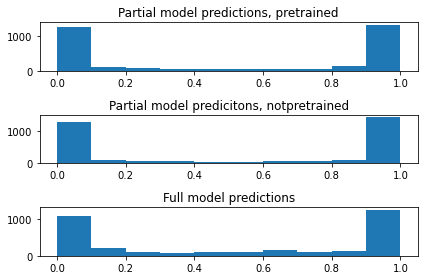

In [6]:
#Parralel modelv2

parallelv2=parallelmodel1(trained)


pretrainedpartialnetwork=parallelv2.pretrainednetwork
untrainedpartialnetwork=parallelv2.untrainednetwork
outputpartialnetwork=parallelv2.outputlayer






parallelv2.to(device)
criterion_pretrained = nn.BCELoss()
criterion_untrained = nn.BCELoss()
criterion_output = nn.BCEWithLogitsLoss()




optimizer_pretrained=optim.Adam(pretrainedpartialnetwork.parameters(), lr=LEARNING_RATE)
optimizer_untrained=optim.Adam(untrainedpartialnetwork.parameters(), lr=LEARNING_RATE)
optimizer_output=optim.Adam(outputpartialnetwork.parameters(), lr=LEARNING_RATE)


optimize=optim.Adam(parallelv2.parameters(), lr=LEARNING_RATE)


pretrainedlosslist=[]
untrainedlosslist=[]
outputlosslist=[]
totallosslist=[]


parallelv2.train()
for e in range(1, EPOCHS+1):
    epoch_loss_trained = 0
    epoch_loss_untrained=0
    epoch_loss_outputlayer=0
    epoch_loss_total=0
    
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_pretrained.zero_grad()
        optimizer_untrained.zero_grad()
        optimizer_output.zero_grad()

        y_pred = parallelv2(X_batch)
        y_pred_trained=pretrainedpartialnetwork(X_batch)
        y_pred_untrained=untrainedpartialnetwork(X_batch)
        
        
        
        loss_pretrained = criterion_pretrained(y_pred_trained, y_batch.unsqueeze(1))
        loss_untrained = criterion_untrained(y_pred_untrained, y_batch.unsqueeze(1))
        loss_output = criterion_output(y_pred, y_batch.unsqueeze(1))
        loss=loss_pretrained+loss_untrained+loss_output
        loss.backward()
        
        
        #loss_pretrained.backward()
        #loss_untrained.backward()
        #loss_output.backward()
        
        
        #optimizer_pretrained.step()
        #optimizer_untrained.step()
        #optimizer_output.step()
        
        optimize.step()
        
        
        #loss.backward()
        #verallopt.step()
        
        
        
        epoch_loss_trained += loss_pretrained.item()
        epoch_loss_untrained+=loss_untrained.item()
        epoch_loss_outputlayer+=loss_output.item()
        
        
        
        #epoch_loss += loss.item()
        
    epoch_loss_total=epoch_loss_trained+epoch_loss_untrained+epoch_loss_outputlayer
    pretrainedlosslist.append(epoch_loss_trained/len(train_loader))
    untrainedlosslist.append(epoch_loss_untrained/len(train_loader))
    outputlosslist.append(epoch_loss_outputlayer/len(train_loader))
    totallosslist.append(epoch_loss_total/len(train_loader))

    
    
        
        
        
        
        
y_parmodelpred_list =[]
parallelv2.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = parallelv2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_parmodelpred_list.append(y_pred_tag.cpu().numpy())


y_parmodelpred_list = [a.squeeze().tolist() for a in y_parmodelpred_list]


#print(y_parmodelpred_list)
    
parmodelcounter=0
for i in range(len(y_parmodelpred_list)):
    if y_parmodelpred_list[i]==y_test[i]:
        parmodelcounter=parmodelcounter+1       

print("# correct: ",parmodelcounter, " out of ", len(y_test))
        
print("Full model statistics")
print(classification_report(y_test, y_parmodelpred_list))    
    
        

        
        
   

        
        
        
        
        
y_parmodelpred_list =[]
pretrainedpartialnetwork.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = pretrainedpartialnetwork(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_parmodelpred_list.append(y_pred_tag.cpu().numpy())


y_parmodelpred_list = [a.squeeze().tolist() for a in y_parmodelpred_list]


#print(y_parmodelpred_list)
    
parmodelcounter=0
for i in range(len(y_parmodelpred_list)):
    if y_parmodelpred_list[i]==y_test[i]:
        parmodelcounter=parmodelcounter+1       

print("# correct: ",parmodelcounter, " out of ", len(y_test))
        
print("pretrained model statistics")
print(classification_report(y_test, y_parmodelpred_list))    
   
    
    

        
y_parmodelpred_list =[]
untrainedpartialnetwork.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = untrainedpartialnetwork(X_batch)
        #y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_parmodelpred_list.append(y_pred_tag.cpu().numpy())


y_parmodelpred_list = [a.squeeze().tolist() for a in y_parmodelpred_list]


#print(y_parmodelpred_list)
    
parmodelcounter=0
for i in range(len(y_parmodelpred_list)):
    if y_parmodelpred_list[i]==y_test[i]:
        parmodelcounter=parmodelcounter+1       

print("# correct: ",parmodelcounter, " out of ", len(y_test))
        
print("untrained model statistics")
print(classification_report(y_test, y_parmodelpred_list))    
 
        

        

#histograms
xbins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
fig=plt.figure()
trained_histo=fig.add_subplot(3,1,1)
untrained_histo=fig.add_subplot(3,1,2)
full_histo=fig.add_subplot(3,1,3)

n, bins, patches = trained_histo.hist(y_pretrainedunrounded,xbins)
n, bins, patches = untrained_histo.hist(y_untrained_unrounded,xbins)
n, bins, patches = full_histo.hist(yparralelunrounded,xbins)




untrained_histo.set_title('Partial model predicitons, notpretrained')
trained_histo.set_title("Partial model predictions, pretrained")
full_histo.set_title("Full model predictions")
fig.tight_layout()



#plt.savefig('HIST_TRe2_N64_D10000_FULL_NOBIAS')
        
        



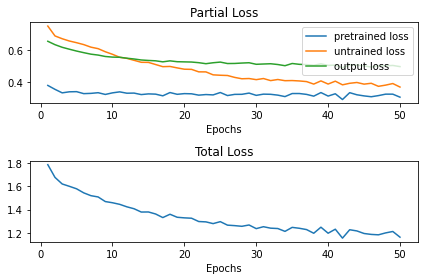

In [7]:
#partial loss graph
epochlist=list(range(1, EPOCHS+1))
#print(epochlist)
fig, (partial_loss, total_loss) = plt.subplots(2)


partial_loss.plot(epochlist,pretrainedlosslist, label="pretrained loss")
partial_loss.plot(epochlist,untrainedlosslist, label="untrained loss")
partial_loss.plot(epochlist,outputlosslist, label="output loss")



partial_loss.set_xlabel('Epochs')
partial_loss.set_label('Loss')
partial_loss.set_title('Partial Loss')


partial_loss.legend()


plt.plot(epochlist,totallosslist,label="total loss")


total_loss.set_xlabel('Epochs')
total_loss.set_label('Loss')
total_loss.set_title('Total Loss')
fig.tight_layout()






# correct:  1707  out of  3300
Full model statistics
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1593
         1.0       0.52      1.00      0.68      1707

    accuracy                           0.52      3300
   macro avg       0.26      0.50      0.34      3300
weighted avg       0.27      0.52      0.35      3300

output weight:  Parameter containing:
tensor([[1.0000, 0.4755]], requires_grad=True)
pretrained stats:
Tained half model;
Number correct model:  2945  out of  3300
precision=(# of correct)/(# of guessed)
recall=(# of correct)/(total)
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      1593
         1.0       0.94      0.85      0.89      1707

    accuracy                           0.89      3300
   macro avg       0.90      0.89      0.89      3300
weighted avg       0.90      0.89      0.89      3300

untrained half stats:
untained half model;
Number correct m

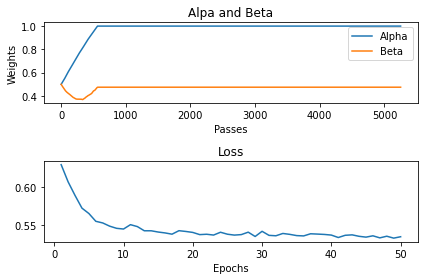

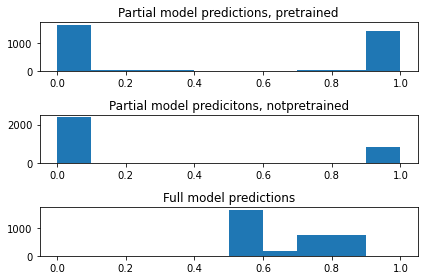

In [8]:
#alpha beta probabilities
parralel = parallelmodel(trained)
parralel.to(device)
criterion = nn.BCEWithLogitsLoss()

parralel.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[.5,0.5]]), requires_grad=True)
parralel.alpha.append(.5)
parralel.beta.append(.5)
epochlist=[]
losslist=[]

paroptimizer = optim.Adam(parralel.parameters(), lr=LEARNING_RATE)



#EPOCHS = 300 #number of passes of whole data
#BATCH_SIZE = 16 #size of data going through at once



#train trained model
parralel.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        paroptimizer.zero_grad()
        
        y_pred = parralel(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        paroptimizer.step()
        
        parralel.alpha.append(parralel.outputlayer.weight[0][0].detach().numpy().item())
        parralel.beta.append(parralel.outputlayer.weight[0][1].detach().numpy().item())
        
        weight1=parralel.outputlayer.weight[0][0].detach().numpy().item()
        weight2=parralel.outputlayer.weight[0][1].detach().numpy().item()
        if weight1>1:
            parralel.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[1,weight2]]), requires_grad=True)

            
        elif weight1<0:
            parralel.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[0,weight2]]), requires_grad=True)

            
        if weight2>1:
            parralel.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[weight1,1]]), requires_grad=True)

            
        elif weight2<0:
            parralel.outputlayer.weight=torch.nn.Parameter(data=torch.tensor([[weight1,0]]), requires_grad=True)

            
            
            
        epoch_loss += loss.item()

        epoch_acc += acc.item()
        
        

        
    epochlist.append(e)   
    losslist.append(epoch_loss/len(train_loader))
    #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

    
passlist=list(range(0,len(parralel.alpha)))



yparralelunrounded=[]
y_parmodelpred_list =[]
parralel.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = parralel(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        yparralelunrounded.append(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_parmodelpred_list.append(y_pred_tag.cpu().numpy())


y_parmodelpred_list = [a.squeeze().tolist() for a in y_parmodelpred_list]
yparralelunrounded = [a.squeeze().tolist() for a in yparralelunrounded]


#print(y_parmodelpred_list)
    
parmodelcounter=0
for i in range(len(y_parmodelpred_list)):
    if y_parmodelpred_list[i]==y_test[i]:
        parmodelcounter=parmodelcounter+1       

print("# correct: ",parmodelcounter, " out of ", len(y_test))
        
print("Full model statistics")
print(classification_report(y_test, y_parmodelpred_list))    
    
    
print("output weight: ", parralel.outputlayer.weight)





#half model stats

halfmodeltrained=binaryClassification()
halfmodellow=binaryClassification()

halfmodeltrained.layer_1 = copy.deepcopy(parralel.layer1_1)
halfmodeltrained.layer_2 = copy.deepcopy(parralel.layer1_2)
halfmodeltrained.layer_3 = copy.deepcopy(parralel.layer1_3)
halfmodeltrained.layer_4 = copy.deepcopy(parralel.layer1_4)
halfmodeltrained.layer_5 = copy.deepcopy(parralel.layer1_5)
halfmodeltrained.layer_out = copy.deepcopy(parralel.layer1_out)



halfmodeltrained.batchnorm1 = parralel.batchnorm1_1
halfmodeltrained.batchnorm2 = parralel.batchnorm1_2
halfmodeltrained.batchnorm3 = parralel.batchnorm1_3
halfmodeltrained.batchnorm4 = parralel.batchnorm1_4
halfmodeltrained.batchnorm5 = parralel.batchnorm1_5











halfmodellow.layer_1 = copy.deepcopy(parralel.layer2_1)
halfmodellow.layer_2 = copy.deepcopy(parralel.layer2_2)
halfmodellow.layer_3 = copy.deepcopy(parralel.layer2_3)
halfmodellow.layer_4 = copy.deepcopy(parralel.layer2_4)
halfmodellow.layer_5 = copy.deepcopy(parralel.layer2_5)
halfmodellow.layer_out = copy.deepcopy(parralel.layer2_out)



halfmodellow.batchnorm1 = parralel.batchnorm2_1
halfmodellow.batchnorm2 = parralel.batchnorm2_2
halfmodellow.batchnorm3 = parralel.batchnorm2_3
halfmodellow.batchnorm4 = parralel.batchnorm2_4
halfmodellow.batchnorm5 = parralel.batchnorm2_5

print("pretrained stats:")



y_pretrianedlist =[]
y_pretrainedunrounded=[]
halfmodeltrained.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = halfmodeltrained(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pretrainedunrounded.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_pretrianedlist.append(y_pred_tag.cpu().numpy())


y_pretrianedlist = [a.squeeze().tolist() for a in y_pretrianedlist]
y_pretrainedunrounded = [a.squeeze().tolist() for a in y_pretrainedunrounded]



correctcounter=0
for i in range(len(y_pretrianedlist)):
    if y_pretrianedlist[i]==y_test[i]:
        correctcounter=correctcounter+1 
        
        
print("Tained half model;")
print("Number correct model: ", correctcounter, " out of ", len(y_test))
print("precision=(# of correct)/(# of guessed)")
print("recall=(# of correct)/(total)")
print(classification_report(y_test, y_pretrianedlist))





print("untrained half stats:")
y_untrianedlist =[]
y_untrained_unrounded=[]
halfmodellow.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = halfmodellow(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_untrained_unrounded.append(y_test_pred.cpu().numpy())
        y_pred_tag = torch.round(y_test_pred)
        y_untrianedlist.append(y_pred_tag.cpu().numpy())


y_untrianedlist = [a.squeeze().tolist() for a in y_untrianedlist]
y_untrained_unrounded = [a.squeeze().tolist() for a in y_untrained_unrounded]



correctcounter=0
for i in range(len(y_pretrianedlist)):
    if y_untrianedlist[i]==y_test[i]:
        correctcounter=correctcounter+1 
        

        
        
print("untained half model;")
print("Number correct model: ", correctcounter, " out of ", len(y_test))
print("precision=(# of correct)/(# of guessed)")
print("recall=(# of correct)/(total)")
print(classification_report(y_test, y_untrianedlist))









#graphs

fig, (weights, lossgraph) = plt.subplots(2)
weights.plot(passlist,parralel.alpha, label="Alpha")
weights.plot(passlist,parralel.beta, label="Beta")
weights.legend()

weights.set_xlabel('Passes')
weights.set_ylabel('Weights')
weights.set_title('Alpa and Beta')




plt.plot(epochlist,losslist, label="loss")

lossgraph.set_xlabel('Epochs')
lossgraph.set_label('Loss')
lossgraph.set_title('Loss')


fig.tight_layout()
#plt.savefig('e2fullparalelgraph3')






xbins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
fig=plt.figure()
trained_histo=fig.add_subplot(3,1,1)
untrained_histo=fig.add_subplot(3,1,2)
full_histo=fig.add_subplot(3,1,3)

n, bins, patches = trained_histo.hist(y_pretrainedunrounded,xbins)
n, bins, patches = untrained_histo.hist(y_untrained_unrounded,xbins)
n, bins, patches = full_histo.hist(yparralelunrounded,xbins)




untrained_histo.set_title('Partial model predicitons, notpretrained')
trained_histo.set_title("Partial model predictions, pretrained")
full_histo.set_title("Full model predictions")
fig.tight_layout()






